# Insurance expenses prediction

The main goal of this notebook is to present a normal workflow of a regression problem. We will present first a
exploratory data analyis (EDA), then we will use some out-of-the-box results, follow by the use of pipelines to improve
the estimation, and at the end give the final conclusions. In this notebook is explored how to fit multiple ML models
to try to predict the policyholder insurance charges. The data was generated by of
[Brett Lantz](https://www.linkedin.com/in/brettlantz/) base on the U.S. Census Bureau database.

In particular, this notebook presents
* <b>EDA</b>: Exploratory Data Analysis to understand the problem.
* <b>Pipeline and Cross validation fitting</b>: We compare the results of an out-of-the-box fitting of the models:
    * <b>Lineal regression</b>
    * <b>Lasso</b>
    * <b>Ridge</b>
    * <b>Random Forest</b>
    * <b>XGBoost</b>
* <b>Random Search</b>: we further explore the `random forest` and `XGBoost` models, using a `random search` for their
parameters
* <b>Neural Networks with Cross-Validation</b>: We further compare the results of the models against a `neural network`.
* <b>Conclusions<b>


This type of analysis are useful for insurance companies since they help to narrow the policyholder's costs and
increase revenue to the company. In general, an insurance company needs to collect more in yearly premiums than it
spends on medical care to its beneficiaries. As a result, insurers invest a great deal of time and money to develop
models that accurately forecast medical expenses.

The main goal of this analysis is to use patient information to estimate the medical care expenses that could happen in
the duration of the contract. Moreover, the estimators could be used to create actuarial tables that are also mandatory
under the Solvency II framework.

**The Docker image for this notebook could be dowloaded from** [here](https://github.com/kaggle/docker-python).


ahoestuhas

<center> <img src="https://www.rushortho.com/sites/default/files/2016-10/AdobeStock_96790805.jpeg" alt="drawing" width="500"/> <center>


In [7]:
# General computation modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time
import datetime

import statsmodels
import os

# Data transformation modules
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Machine Learning modules
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

# Neural Networks modules
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor


# Possible useful modules
# from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
# from sklearn.model_selection import cross_val_score

## Exploratory Data Analysis

In order predict the charges of a policyholder, we have the following features to train our models:

* <b>age</b>: Age of primary beneficiary.
* <b>sex</b>: Insurance contractor gender, female, male.
* <b>bmi</b>: Body mass index, providing an understanding of body, weights that are relatively high or low relative to
height.
* <b>children</b>: Number of children covered by health insurance / Number of dependents.
* <b>smoker</b>: Smoking yes/no.
* <b>region</b>: The beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* <b>charges</b>: Individual medical costs billed by health insurance.

Let us see the first five rows of information.

In [8]:
df = pd.read_csv("input/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Let us now take a look at the data types of each column; this will be very important to define each feature
transformation that will be the imput of our ML models.Also, let us notice that the data does not has any missing value.

In [9]:
df.info() # Also we could use 'df.isnull().sum()'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In the next cells we present some insides about the data. In particular, we notice that
* <b>No remarkable outlier</b>: it seems that the population has not any outlier since the ranges of values does not
present any weird behaviour.
* <b>Smoking plays an important factor in the charges</b>: There is a remarkable change in the distribution of smokers vr
no-smokers. This could be witness in the violin graphs of `charges` vr `sex` filtered by `smoke`. Higher charges are
presented in the smoker population. This is also shown by the plot of `charges` vr `smoke` by fitting a logistic
regression; we could predict that the person is an smoker by only considering that has a big charge in its insurance!
* <b>Women present more variation in their charges</b>: There is a noticeable difference between the charges of male and
female in terms of their variance.
* <b>Older population with higher charges</b>: By plotting the `charges` vr `age` we could see an increase as the person
is older.
* <b>No apparent difference in charges between regions</b>: by plotting `region` vr `charges` as a violin graph, we
do not see any remarkable difference between region's charges.

Let us present our findings in the next cells.

In [10]:
df.describe() # Also we could use 'df.isnull().sum()'

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Let us separate the data into train and test sets.

/Users/arrigocoen/Dropbox/GitHub/2021 Repos/RNN/Enviroments/Python3_9_Mac/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='charges', ylabel='Density'>

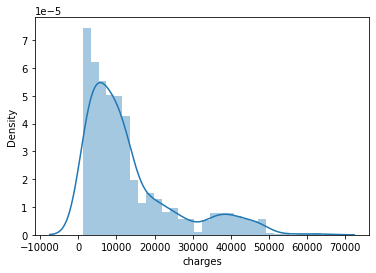

In [11]:
sns.distplot(df['charges'])

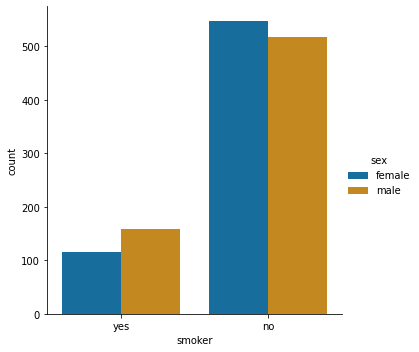

In [12]:
my_palette = ['colorblind', 'deep', 'pink', 'magma'][0]
sns.catplot(x="smoker", kind="count",hue = 'sex', palette=my_palette, data=df)

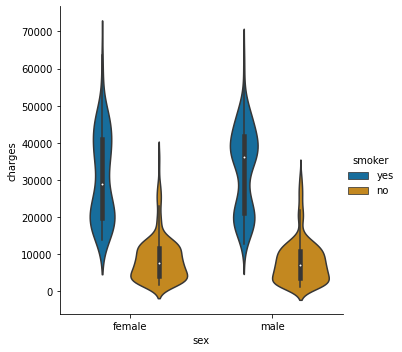

In [13]:
my_palette = ['colorblind', 'deep', 'pink', 'magma'][0]

sns.catplot(x="sex", y="charges", hue="smoker",
            kind="violin", data=df, palette = my_palette)


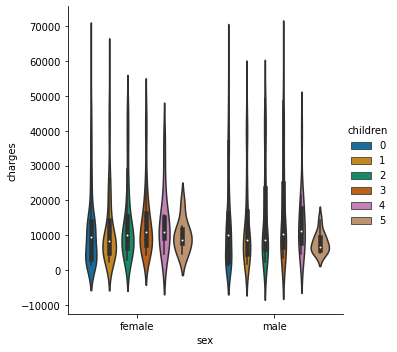

In [14]:
sns.catplot(x="sex", y="charges", hue="children",
            kind="violin", data=df, palette = my_palette)


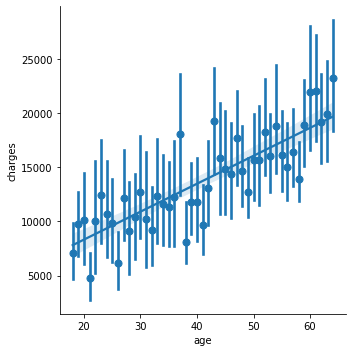

In [15]:
sns.lmplot(x="age", y="charges", data=df, x_estimator=np.mean)


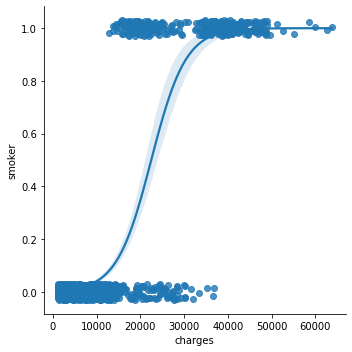

In [16]:
# We need to transfor in to a numeric column the feature `smoker` to use `sns.lmplot`
df_numeric = df.copy()
df_numeric['smoker'] = df_numeric.smoker.replace(to_replace=['no', 'yes'], value=[0, 1])
sns.lmplot(x="charges", y="smoker", y_jitter=.03, logistic=True, data=df_numeric)

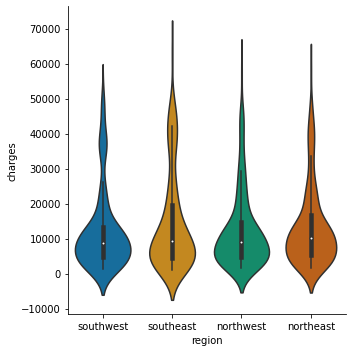

In [17]:
sns.catplot(x="region", y="charges", # hue="children",
            kind="violin", data=df, palette = my_palette)

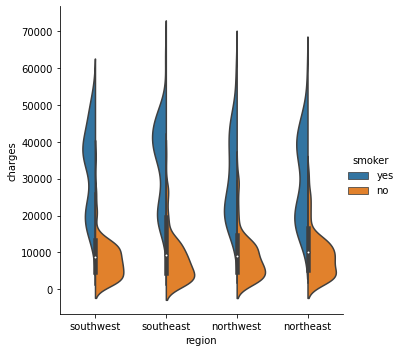

In [18]:
sns.catplot(x="region", y="charges",
            hue="smoker", # Grouping variable that will produce elements with different colors.
            kind="violin", # Options are: "point", "bar", "strip", "swarm", "box", "violin", or "boxen"
            split=True,
            data=df)

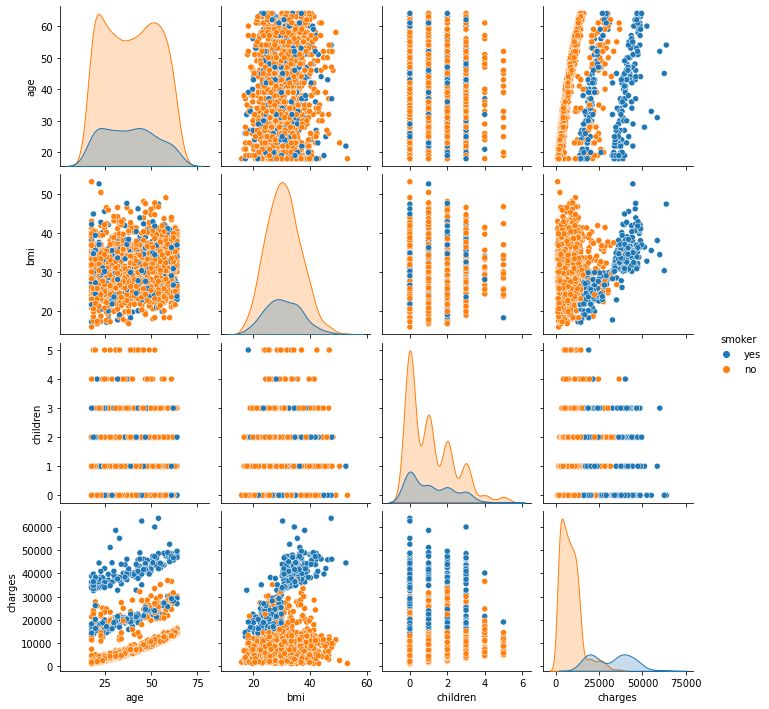

In [19]:
sns.pairplot(hue="smoker", # Grouping variable that will produce elements with different colors.
             data=df)


## Methodology

Let us now continue with some out-of-the-box model to define a baseline of predictions. In particular, we will fit the
models `LinearRegression`, `Lasso` , `Ridge` `RandomForestRegressor`, and `XGBRegressor`. Accordingly, let us separate
the data into features (`X`) and target (`y`), followed by dividing it by train and test sets.

In [20]:
X = df.drop('charges', axis=1)
y = df.charges
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

To apply our regression algorithms we first use the next column transformer. In applies one-hot-encoder to the
categorical variables (`sex`,`smoker` and `region`) and standardizes the reminder numerical ones (`age`, `bmi` and
`children`). Moreover, since we do not have any missing values, we do not need to do any imputation. We use the
`make_column_transformer` routine since we are going to use pipelines and cross-validation.

In [21]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')

Now we define a couple of functions to present the estimation errors of each algorithm. The function `model_results`
applies a 5-fold cross-validation to the model that he gets as an input and saves the results inthe `results_df`
dataframe. The function `normalized_bar_plot` displays a bar plot of the models cross-validation errors; is important to
notices that we normalize the values of the errors since they are in different magnitudes. This bar plot shows which
model has a better fit to the data in comparison to the other models.

In particular, we are studying the Mean Square Error (MSE) and the Mean Absolute Error (MAE) with respect to the
cross-validation, by analyzing their CV-mean and CV-std.

LinearRegression


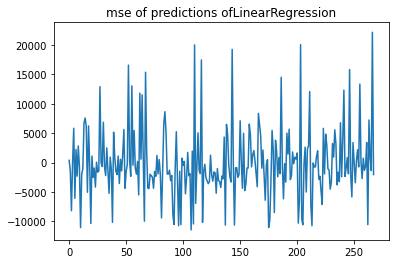

Lasso


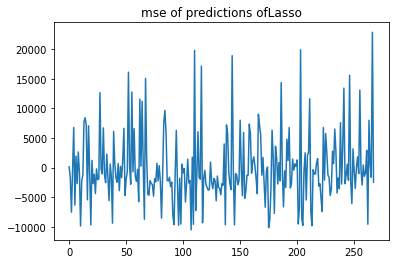

Ridge


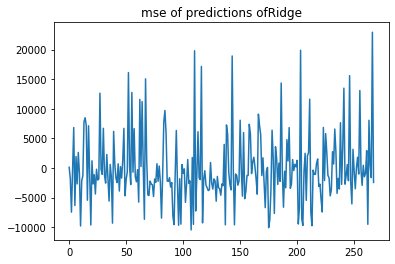

,model,rmse_mean,rmse_std,mae_mean,mae_std
0,LinearRegression,6155.112802,4.956161e+06,64.995007,265.229978
1,Lasso,6146.783657,5.028188e+06,65.126862,244.462377
2,Ridge,6146.993987,5.004419e+06,65.168117,243.363537


In [22]:
def model_results(model, results_df, model_name=None, verbose=0):
    """
    Given a model this function updats the dataframe results_df with the model's cross-validation (CV) results. This
    function also plots the errors with respect to the X_test and y_test sets.
    :param model: a machine learning model; eg. LinearRegression()
    :param results_df: a pd.DataFrame with the current CV information of the models
    :param model_name: an extra string with the name that will be use the information of the model. This variables
    is useful in case of having different instances of the model with different parameters. In case of None, it
    uses type(model).__name__
    :return: an update version of results_df with the `model`'s information
    """
    # Name of the model
    if model_name is None:
        model_name = type(model).__name__
    print(model_name)
    # Pipeline to do a cross validation
    pipe = make_pipeline(column_trans, model)
    # Results of the CV
    c_scores = cross_validate(pipe, X_train, y_train, cv=5,
                              scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
                              verbose=verbose, n_jobs=-1)
    # Extracting CV results
    mse_mean = np.sqrt(np.array(-c_scores['test_neg_mean_squared_error'])).mean()
    mse_std = c_scores['test_neg_mean_squared_error'].std()
    mae_mean =  np.sqrt(np.array(-c_scores['test_neg_mean_absolute_error'])).mean()
    mae_std = c_scores['test_neg_mean_absolute_error'].std()    
    fit_time_mean = c_scores['fit_time'].mean()
    # We define the new row of results_df
    new_row = [model_name, mse_mean, mse_std, mae_mean, mae_std]
    # Plot of predictions
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    plt.plot(np.array(y_test)-y_pred)
    plt.title("mse of predictions of"+model_name)
    plt.show()
    # This if take cares of the case when resuls_df is empty
    if results_df.iloc[0,0]== 0:
        results_df.loc[0] = new_row
    else:
        results_df.loc[len(results_df.index)] = new_row
    return results_df

def normalized_bar_plot(results_df):
    """
    Bar plot of the normalized erros
    :param results_df: data frame with the model`s cross-validation errors.
    :return:
    """
    normalized_df = results_df.copy()
    normalized_df.iloc[:,1:]=(results_df.iloc[:,1:].copy())/results_df.iloc[:,1:].max()
    normalized_df.plot(x="model", y=['rmse_mean', 'rmse_std', 'mae_mean', 'mae_std'], kind="bar")
    # plt.ylim([0,2])
    plt.title("Equivalent magnitudes of results")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

col_results = ['model', 'rmse_mean', 'rmse_std', 'mae_mean', 'mae_std']
models = [LinearRegression(), Lasso(), Ridge(), RandomForestRegressor(), XGBRegressor()]
models = [LinearRegression(), Lasso(), Ridge()]
# models = [LinearRegression(), Lasso(), Ridge()]
results_df = pd.DataFrame(np.zeros([1,len(col_results)]), columns=col_results)

for i, model in enumerate(models):
    results_df = model_results(model, results_df)


results_df


Let us plot an scaled version of the `results_df` to compare graphically the models. For scaled version we mean that we
divide each value between the maximum value, to scale each of the numeric columns of `results_df`.

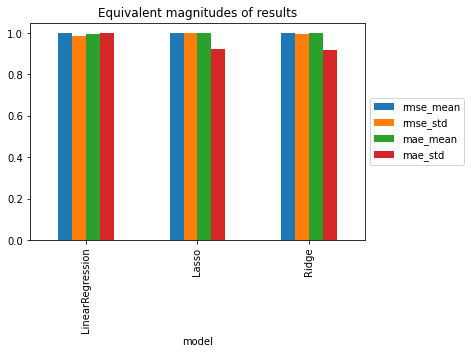

In [23]:
normalized_bar_plot(results_df)

We can see that the best out-of-the-box models were the `RandomForestRegressor()` and `XGBRegressor()`. Accordingly, in
the next sections we will fine tune these two models using `GridSearchCV` to find their parameters and `Pipeline` to
control the workflow.

# Randomized Search CV for Random Forest

In [24]:
# each of these models will take a turn as the second Pipeline step
model_1 = RandomForestRegressor()


ct = make_pipeline(column_trans,StandardScaler())

# create the Pipeline
pipe = Pipeline([('preprocessor', ct), ('model', model_1)])

params1 = {}
params1['model__bootstrap'] = [True, False]
params1['model__max_depth'] = [70, 80, 90, 100, 110]
params1['model__max_features'] = [2, 3, 4, 6, 10]
params1['model__min_samples_leaf'] = [2, 3, 4, 5, 6]
params1['model__min_samples_split'] = [5, 8, 10, 12]
params1['model__n_estimators'] = [200, 300, 500, 1000]
params1['model'] = [model_1]

params = [params1]

# In case of having more that one model define: # params = [params1, params2]
grid_RF = RandomizedSearchCV(pipe, params, n_jobs=-1, n_iter=20, verbose=1, cv=3, scoring='neg_mean_squared_error',
                             random_state = 42)
grid_RF.fit(X_train, y_train)
grid_RF.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'model__n_estimators': 1000,
 'model__min_samples_split': 8,
 'model__min_samples_leaf': 5,
 'model__max_features': 6,
 'model__max_depth': 90,
 'model__bootstrap': True,
 'model': RandomForestRegressor(max_depth=90, max_features=6, min_samples_leaf=5,
                       min_samples_split=8, n_estimators=1000)}

RandomForestRegressor_Tuned


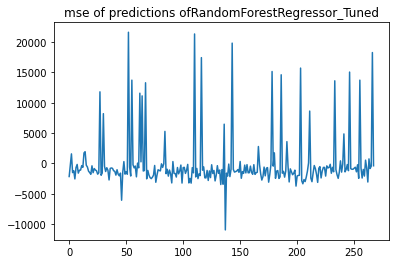

,model,rmse_mean,rmse_std,mae_mean,mae_std
0,LinearRegression,6155.112802,4.956161e+06,64.995007,265.229978
1,Lasso,6146.783657,5.028188e+06,65.126862,244.462377
2,Ridge,6146.993987,5.004419e+06,65.168117,243.363537
3,RandomForestRegressor_Tuned,4606.962956,4.586996e+06,51.051526,152.480223


In [25]:
model = grid_RF.best_params_['model']
results_df = model_results(model, results_df, model_name = 'RandomForestRegressor_Tuned')
results_df

We notice an improvement of the random forest model after tuning it. So, it continues being our best model.

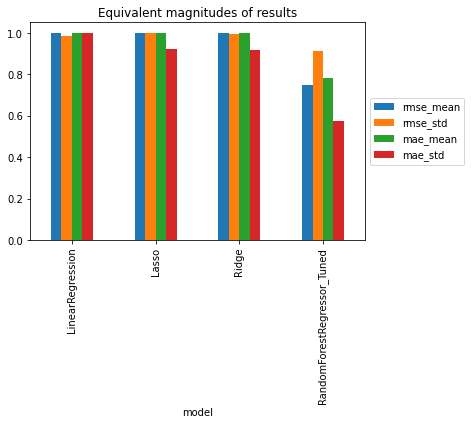

In [26]:
normalized_bar_plot(results_df)


## Tuning XBGregression

In [27]:
print(datetime.datetime.now())


# Start
model_1 = XGBRegressor()
ct = make_pipeline(column_trans)
# create the Pipeline
pipe = Pipeline([('preprocessor', ct), ('model', model_1)])

my_n_estimators = 1000

params1 = {}
# params1['model__gamma'] = [0]
params1['model__eta'] = [0.4, 0.3, 0.1, 0.01]
params1['model__max_depth'] = [1, 2, 3, 4]
params1['model__n_estimators'] = [my_n_estimators]
params1['model__subsample'] = sp.stats.uniform(scale=1)
params1['model__colsample_bytree'] = sp.stats.uniform(scale=1)

params1['model'] = [model_1]

grid_XGB = RandomizedSearchCV(pipe, params1, n_jobs=-1, n_iter=20, verbose=1, cv=3, random_state = 42)

# print(grid)
grid_XGB.fit(X_train, y_train)
grid_XGB.best_params_

2021-12-02 11:10:25.430245
Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'model': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.9488855372533332,
              enable_categorical=False, eta=0.01, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.8083973481164611,
              tree_method=None, validate_parameters=None, verbosity=None),
 'model__colsample_bytree': 0.9488855372533332,
 'model__eta': 0.01,
 'model__max_depth': 2,
 'model__n_estimators': 1000,
 'model__subsample': 0.8083973481164611}

XGBRegressor_Tuned


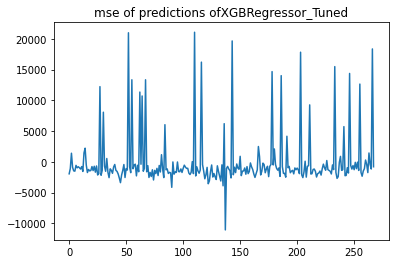

,model,rmse_mean,rmse_std,mae_mean,mae_std
0,LinearRegression,6155.112802,4.956161e+06,64.995007,265.229978
1,Lasso,6146.783657,5.028188e+06,65.126862,244.462377
2,Ridge,6146.993987,5.004419e+06,65.168117,243.363537
3,RandomForestRegressor_Tuned,4606.962956,4.586996e+06,51.051526,152.480223
4,XGBRegressor_Tuned,4561.955219,4.740726e+06,50.765572,154.377911


In [28]:
model = grid_XGB.best_params_['model']

results_df = model_results(model, results_df, model_name = 'XGBRegressor_Tuned')
results_df

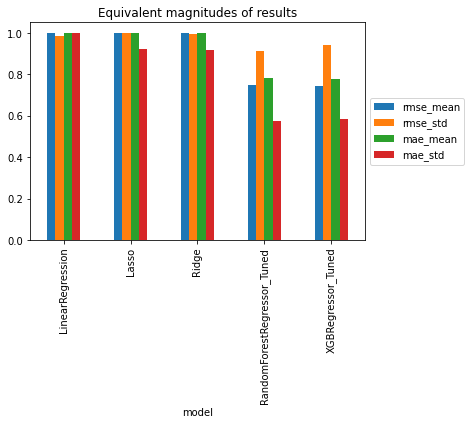

In [29]:
normalized_bar_plot(results_df)

After tuning the XGBoost model we get an improvement on the MSE in comparison to the Random Forest model tuned. So, our
current best model is the `XGBRegressor_Tuned`.

# Neural Networks

Now, let us change gears a little and consider a Neural Network model to predict the charges. After doing some testing,
we found that we do not need a very deep network neither its layes need to have many neurons. We use a five layer with
a first layer of 128 neurons and the others of 64. Since we have a regression problem we define a final layers of one
neuron. Also, our test show that the activation `relu` was good enough and that no dropout layers were needed.

As a loss function we choose the MSE, and we found that 80 epochs were enough to not overfit. We recommend changing the
`verbose` parameter of `model.fit` to get more information about the fitting of the network to the train and test sets.

In [ ]:
column_trans_NN = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')

X_train_ct = column_trans_NN.fit_transform(X_train)
X_test_ct = column_trans_NN.transform(X_test)

model = Sequential()
model.add(Dense(128, input_dim=len(column_trans_NN.fit_transform(X_train)[0]),  activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()
# create the Pipeline

# pipe = make_pipeline(column_trans,StandardScaler(), model)
history = model.fit(X_train_ct, y_train, epochs = 100, validation_split = 0.1, batch_size=1, verbose = 1)
y_pred = model.predict(X_test_ct)


mse_test_pred = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test_pred = mean_absolute_error(y_test, y_pred)
print("rmse test = ",mse_test_pred)
print("mae test = ",mae_test_pred)
plt.plot(np.array(y_test)-[i[0] for i in y_pred])
plt.show()

skip_to_plot = 2
plt.plot(history.history['loss'][skip_to_plot:])
plt.plot(history.history['val_loss'][skip_to_plot:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train error', 'val error'], loc='upper left')
plt.show()

2021-12-02 11:11:01.457565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1536      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 14,017
Trainable params: 14,017
Non-trainable params: 0
_________________________________________________________________


2021-12-02 11:11:02.927921: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
963/963 [==============================] - 2s 2ms/step - loss: 146031200.0000 - val_loss: 54301484.0000

An important element of our network is the dropout layer. It helps us to not overfit as could be seen in the graph of
the train vr test error. We perform test without it and the network memorizes the data. This is something that we could
expect since we do not have many data instances.

To use our pipeline we define the function create_network to wrap our neural network model in to a proper input for
the cross-validation rutine that we have.

In [ ]:
column_trans_NN = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')

X_train_ct = column_trans_NN.fit_transform(X_train)
X_test_ct = column_trans_NN.transform(X_test)

# Create function returning a compiled network
def create_network():
    model = Sequential()
    model.add(Dense(128, input_dim=len(column_trans_NN.fit_transform(X_train)[0]), activation='relu'))
    model.add(Dropout(0.10))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))
    # Compile model
    # model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Return compiled network
    return model
# evaluate model
model = KerasRegressor(build_fn=create_network, epochs=80, batch_size=1, verbose=0)

In [ ]:
results_df = model_results(model, results_df, model_name = 'Sequential',verbose=3)
results_df

In [ ]:
normalized_bar_plot(results_df)

The last plot shows that we almost get as small errors with the neural network as the ones with the other models.
Nevertheless, we have a remarkably bigger variance in the MAE CV errors and also the computational time was much bigger
that the ones of the other models.

## Conclussions

- <b>An important factor is the smoking feature</b>: the charges are much bigger on people that smokes that on people
that don't. Using the weight of `linel regression` and `Random Forest` algorithms we could see that these two features
are very important.
- <b>Random Forest gives a good and fast fit</b>: the Random Forest algorithm give us the smallest errors in comparison
to other models. Moreover, the time to train this model was also small. This model has a good equilibrium between
accuracy and computational time for the data that we are analyzing.
- <b>A bigger data set could be useful to improve the analysis</b>: In this notebook we study a relative small data set to analyze the behavior
of the charges of the policyholders. More features or more examples could be useful to discover more particularities
of the population. With more data we could have an improvement on the company savings since a better calculation of the costs could represent
a more market competitive prices.

## Useful links:

- Pipelines of scikit learn [link](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/49_tune_multiple_models.ipynb)
- Kaggle version the data [link](https://www.kaggle.com/mirichoi0218/insurance)
- Sequential models [link](https://www.codespeedy.com/the-sequential-model-in-keras-in-python/)
- Regression using Neural Networks [link](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)
- Cross-validation of a network[link](https://chrisalbon.com/code/deep_learning/keras/k-fold_cross-validating_neural_networks/)
- Examples of regression [link](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)
